# Example: CitiBike data

Adapted from Kelsey Jordahl
https://gist.github.com/kjordahl/5957573

In [17]:
%matplotlib inline
import requests  
import json
from pyproj import Proj
from shapely.geometry import Point
import geopandas as gp
import pandas as pd


NYC borough boundaries downloaded from [Bytes of the Big Apple](http://www.nyc.gov/html/dcp/download/bytes/nybb_13a.zip)

In [18]:
boros = gp.GeoDataFrame.from_file('nybb_15b/nybb.shp')
boros.crs

{'init': 'epsg:2263'}

Load real time bike station data from [CitiBike](http://citibikenyc.com) json API:

In [19]:
# get the bike data and convert it to a ditcionary
endpoint_url = 'http://citibikenyc.com/stations/json'
response = requests.get(endpoint_url)
data = json.loads(response.text)
data

{'executionTime': '2019-02-28 09:49:41 AM',
 'stationBeanList': [{'id': 304,
   'stationName': 'Broadway & Battery Pl',
   'availableDocks': 10,
   'totalDocks': 33,
   'latitude': 40.70463334,
   'longitude': -74.01361706,
   'statusValue': 'In Service',
   'statusKey': 1,
   'availableBikes': 23,
   'stAddress1': 'Broadway & Battery Pl',
   'stAddress2': '',
   'city': '',
   'postalCode': '',
   'location': '',
   'altitude': '',
   'testStation': False,
   'lastCommunicationTime': '2019-02-28 09:45:54 AM',
   'landMark': ''},
  {'id': 359,
   'stationName': 'E 47 St & Park Ave',
   'availableDocks': 40,
   'totalDocks': 64,
   'latitude': 40.75510267,
   'longitude': -73.97498696,
   'statusValue': 'In Service',
   'statusKey': 1,
   'availableBikes': 19,
   'stAddress1': 'E 47 St & Park Ave',
   'stAddress2': '',
   'city': '',
   'postalCode': '',
   'location': '',
   'altitude': '',
   'testStation': False,
   'lastCommunicationTime': '2019-02-28 09:47:35 AM',
   'landMark': ''

In [20]:
# convert the relevant part to a geodataframe
df = gp.GeoDataFrame(data['stationBeanList'])
df.head(10)

,altitude,availableBikes,availableDocks,city,id,landMark,lastCommunicationTime,latitude,location,longitude,postalCode,stAddress1,stAddress2,stationName,statusKey,statusValue,testStation,totalDocks
0,,23,10,,304,,2019-02-28 09:45:54 AM,40.704633,,-74.013617,,Broadway & Battery Pl,,Broadway & Battery Pl,1,In Service,False,33
1,,19,40,,359,,2019-02-28 09:47:35 AM,40.755103,,-73.974987,,E 47 St & Park Ave,,E 47 St & Park Ave,1,In Service,False,64
2,,13,32,,377,,2019-02-28 09:47:26 AM,40.722438,,-74.005664,,6 Ave & Canal St,,6 Ave & Canal St,1,In Service,False,45
3,,3,34,,402,,2019-02-28 09:49:37 AM,40.740343,,-73.989551,,Broadway & E 22 St,,Broadway & E 22 St,1,In Service,False,39
4,,22,11,,487,,2019-02-28 09:46:53 AM,40.733143,,-73.975739,,E 20 St & FDR Drive,,E 20 St & FDR Drive,1,In Service,False,34
5,,8,10,,3255,,2019-02-28 09:49:27 AM,40.750585,,-73.994685,,8 Ave & W 31 St,,8 Ave & W 31 St,1,In Service,False,19
6,,8,31,,3443,,2019-02-28 09:49:09 AM,40.761330,,-73.979820,,W 52 St & 6 Ave,,W 52 St & 6 Ave,1,In Service,False,41
7,,25,29,,72,,2019-02-28 09:48:13 AM,40.767272,,-73.993929,,W 52 St & 11 Ave,,W 52 St & 11 Ave,1,In Service,False,55
8,,31,2,,79,,2019-02-28 09:47:50 AM,40.719116,,-74.006667,,Franklin St & W Broadway,,Franklin St & W Broadway,1,In Service,False,33
9,,23,3,,82,,2019-02-28 09:48:42 AM,40.711174,,-74.000165,,St James Pl & Pearl St,,St James Pl & Pearl St,1,In Service,False,27


In [21]:
# there is one row for each bike station.  How many stations are there? 
len(df)

815

In [22]:
# in the file above, there are lon-lats, but no geometry field
# we need to set that up
df['geometry'] = gp.GeoSeries([Point(x, y) for x, y in zip(df['longitude'], df['latitude'])])
df.crs = {'init': 'epsg:4326', 'no_defs': True}
df.geometry.total_bounds

array([-74.0836394 ,  40.65539977, -73.56891632,  45.50598598])

In [23]:
import os
os.environ["PROJ_LIB"] = "C:\Anaconda3\envs\env_name\Library\share"
# make sure they are on the same CRS.  
# checking the bounds is a nice way of seeing this
df.to_crs(boros.crs, inplace=True)
df.geometry.total_bounds

RuntimeError: b'no arguments in initialization list'

In [8]:
# the geometry objects can do lots of cool stuff.  For example: 

manhattan = boros.geometry[3]
in_mn = df.geometry.within(manhattan)
print(sum(in_mn), 'stations in Manhattan')
boros

0 stations in Manhattan


,BoroCode,BoroName,Shape_Leng,Shape_Area,geometry
0,5,Staten Island,330466.075042,1.623827e+09,(POLYGON ((970217.0223999023 145643.3322143555...
1,3,Brooklyn,741185.900596,1.937597e+09,(POLYGON ((1021176.479003906 151374.7969970703...
2,4,Queens,897040.298576,3.045168e+09,(POLYGON ((1029606.076599121 156073.8142089844...
3,1,Manhattan,358408.460709,6.364467e+08,(POLYGON ((981219.0557861328 188655.3157958984...
4,2,Bronx,464400.198868,1.186973e+09,(POLYGON ((1012821.805786133 229228.2645874023...


# Your turn

You can read about the range of operations available in geopandas here: 
    
http://geopandas.org/index.html

Your assignment is to: 

1. Calculate how many stations are in each borough
2. Calculate how many bikes are currently available in each borough
3. Read about and try at least two new spatial or geometric operations (beyond what I've covered here). 

In [9]:
Statan_Island = df.geometry.within(boros.geometry[0])
Brooklyn = df.geometry.within(boros.geometry[1])
Queens = df.geometry.within(boros.geometry[2])
Manhattan = df.geometry.within(boros.geometry[3])
Bronx = df.geometry.within(boros.geometry[4])

stations = []
stations.append(sum(Statan_Island))
stations.append(sum(Brooklyn))
stations.append(sum(Queens))
stations.append(sum(Manhattan))
stations.append(sum(Bronx))

print(sum(Statan_Island), 'in Statan Island')
print(sum(Brooklyn),  'in Brooklyn')
print(sum(Queens), 'in Queens')
print(sum(Manhattan), 'in Manhattan')
print(sum(Bronx), 'in the Bronx')

0 in Statan Island
0 in Brooklyn
0 in Queens
0 in Manhattan
0 in the Bronx


In [10]:
print(sum(df[Statan_Island]['availableBikes']), 'bikes available in Statan Island')
print(sum(df[Brooklyn]['availableBikes']), 'bikes available in Brooklyn')
print(sum(df[Queens]['availableBikes']), 'bikes available in Queens')
print(sum(df[Manhattan]['availableBikes']), 'bikes available in Manhattan')
print(sum(df[Bronx]['availableBikes']), 'bikes available in the Bronx')

0 bikes available in Statan Island
0 bikes available in Brooklyn
0 bikes available in Queens
0 bikes available in Manhattan
0 bikes available in the Bronx


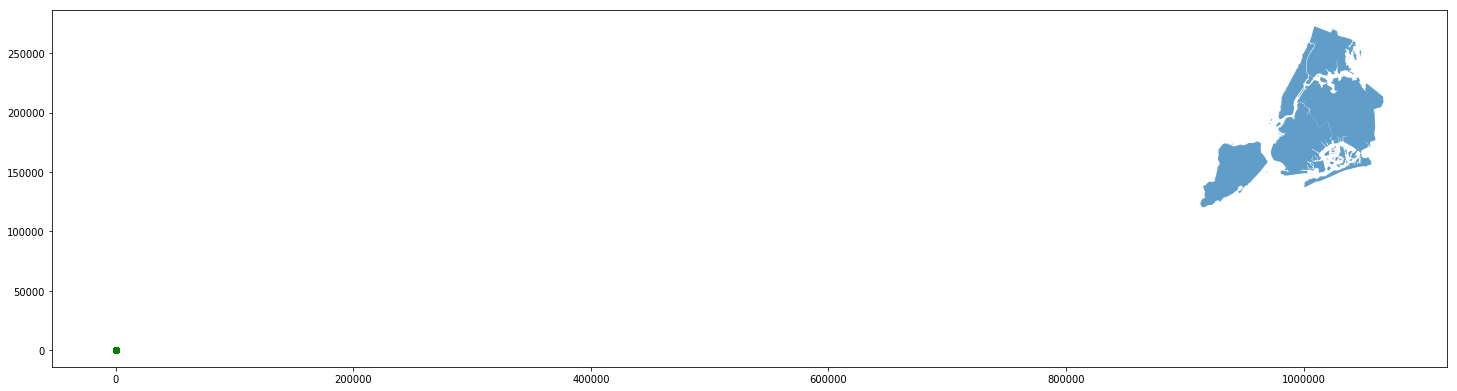

In [11]:
df.plot(figsize=(25, 25),ax=boros.plot(figsize=(25, 25),alpha=75.0), color='Green')

In [15]:
boros['stations'] = stations
boros['station_density'] =  boros['stations'] / boros.geometry.area * 5280 ** 2
boros.sort_values(by='station_density', ascending=False)

,BoroCode,BoroName,Shape_Leng,Shape_Area,geometry,stations,station_density
0,5,Staten Island,330466.075042,1.623827e+09,(POLYGON ((970217.0223999023 145643.3322143555...,0,0.0
1,3,Brooklyn,741185.900596,1.937597e+09,(POLYGON ((1021176.479003906 151374.7969970703...,0,0.0
2,4,Queens,897040.298576,3.045168e+09,(POLYGON ((1029606.076599121 156073.8142089844...,0,0.0
3,1,Manhattan,358408.460709,6.364467e+08,(POLYGON ((981219.0557861328 188655.3157958984...,0,0.0
4,2,Bronx,464400.198868,1.186973e+09,(POLYGON ((1012821.805786133 229228.2645874023...,0,0.0


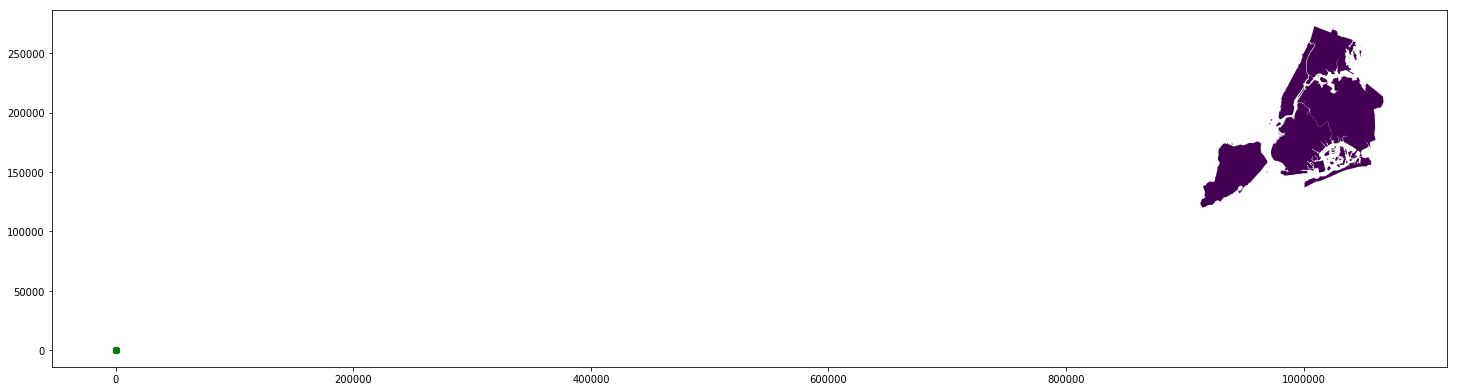

In [16]:
ax=df.plot(figsize=(25, 25) ,color='Green',ax=boros.plot(column='station_density', figsize=(25, 25)))